# Objectif : minimiser le max de la puissance à la racine dans une journée

### Librairies

In [1]:
import pandas as pd
from math import isnan
import numpy as np
from random import randint, uniform
import matplotlib.pyplot as plt
import datetime

### Ouverture des fichiers

In [2]:
file_name_power_limits = "data_opti/limites_puissance.csv"
file_name_consumption_info = "data_opti/info_consommation.csv"
file_name_equipments = "data_opti/equipements.csv"

# Création des df
df_power_limits = pd.read_csv(file_name_power_limits, sep = ';')
df_info_consumption = pd.read_csv(file_name_consumption_info, sep = ';', index_col = 0, decimal = ",")
df_equipments = pd.read_csv(file_name_equipments, sep = ';', index_col = 0, decimal = ",")

# Liste des noms d'équipements et des id de maison
lst_index = list(df_equipments.index.values)
lst_col = list(df_equipments.columns.values)

### Lecture fichier

In [3]:
df_power_limits.head(10)

,min_surface,max_surface,puissance
0,NaN,50.0,3
1,50.0,80.0,6
2,80.0,100.0,9
3,100.0,160.0,12
4,160.0,180.0,15
5,180.0,200.0,25
6,200.0,250.0,30
7,250.0,NaN,36


In [4]:
df_info_consumption.head(10)

,type,puissance,tps_cycle,amperage,hr_debut,hr_max,sequensable
LV,Md1,1.3,1.0,6.0,résultat de l'optimisation,NaN,N
LL,Md2,2.0,1.0,9.0,résultat de l'optimisation,NaN,N
SL,Md3,1.0,4.0,4.0,résultat de l'optimisation,NaN,N
TV,Md4,0.1,NaN,0.5,à générer aléatoirement sur la plage HC,NaN,N
FG,Mc1,0.1,0.2,0.5,à générer 4 fois aléatoirement sur plage HC,NaN,N
CE,Mc2,2.2,6.0,10.0,à générer aléatoirement sur la plage HC,NaN,O
CG,Mc3,0.1,0.2,0.5,à générer 4 fois aléatoirement sur plage HC,NaN,N
FO,Md5,1.6,NaN,12.0,à générer aléatoirement sur la plage HC,NaN,N
PL,Md6,1.2,NaN,20.0,à générer aléatoirement sur la plage HC,NaN,N
FG.1,Mc4,0.3,0.2,3.0,à générer 4 fois aléatoirement sur plage HC,NaN,N


In [5]:
df_equipments.head(7)

,LV,LL,SL,TV,FG,CE,CG,FO,PL,FG.1,CE.1
A100-3-1,1,1,1,1,1,1,0,1,1,1,1
A100-3-10,1,1,1,1,1,1,0,1,1,1,0
A100-3-100,1,1,1,1,1,1,0,1,1,0,0
A100-3-101,1,1,0,1,1,1,1,1,1,0,1
A100-3-102,1,1,1,1,1,1,0,1,1,0,0
A100-3-103,1,1,1,1,1,1,1,1,1,1,0
A100-3-104,1,1,0,1,1,1,0,1,1,0,0


### Tester sur un plus petit jeu de données

In [6]:
df_equipments_short = df_equipments[:100]
lst_index = list(df_equipments_short.index.values)
lst_col = list(df_equipments_short.columns.values)

### Fonctions

In [7]:
# Parse le nom de chaque maison Mxxx-yy-zzz ou appartement Axxx-yy-zzz ou 
#    - Xxx : surface (m²)
#    - Yy : nb occupants
#    - Zzz : repère sur le réseau
def parse_name(lst_name_housing : str) -> dict :
    res = {'type' : [], "surface" : [], "occupants" : [], "id" : []}
    
    for str_id in lst_name_housing:
        name_housing = str_id
        if name_housing[0] == "A" : res['type'].append('appartement')
        else : res['type'].append("maison")

        # Surface m²
        name_housing = name_housing[1:]
        stop = name_housing.find("-")
        res["surface"].append(int(name_housing[:stop]))

        # Nb occupants
        name_housing = name_housing[stop + 1:]
        stop = name_housing.find("-")
        res["occupants"].append(int(name_housing[:stop]))

        # Id 
        res["id"].append(name_housing[stop + 1:])
    
    return res

In [8]:
# Définit la consommation max selon la surface en m²
def max_consumption(df_limits, surface) -> int :
    for index, row in df_limits.iterrows():
        bool1 = (row["min_surface"] < surface) if not(isnan(row["min_surface"])) else True
        bool2 = (surface <= row["max_surface"]) if not(isnan(row["max_surface"])) else True
        if bool1 and bool2 : return row["puissance"]
    return None

In [9]:
def generate_matrice_indiv(str_indiv : str, df_equipment : pd.DataFrame, df_info_consumption : pd.DataFrame, lst_col : list) -> np.array :
    col_name = [i for i in range(0, 24)]
    index_name, lst_tmp_info = [], []
    for i in range(len(lst_col)):
        if df_equipment[lst_col[i]][str_indiv]:
            index_name.append(lst_col[i])
            lst_tmp_info.append([df_info_consumption["tps_cycle"][lst_col[i]], df_info_consumption["puissance"][lst_col[i]]])
    lst_tmp_info = np.array(lst_tmp_info).T
    df_info_tmp = pd.DataFrame(lst_tmp_info, columns = index_name, index = ["tps_cycle", "puissance"])

    # à suppr :
    for col in list(df_info_tmp.columns.values) : 
        if isnan(df_info_tmp[col]["tps_cycle"]):
            df_info_tmp[col]["tps_cycle"] = -1
    i = 0
    
    # Initialisation du résultat  
    res = pd.DataFrame(np.zeros(shape = (len(index_name), 24)), columns = col_name, index = index_name)
    
    lst_equipment_name = list(df_info_tmp.columns.values)
    while i < len(lst_equipment_name) and any([val >= 0 for val in df_info_tmp.loc["tps_cycle"]]):
        lst_equipment_name = list(df_info_tmp.columns.values)
        tps_cycle_argmax = np.argmax(df_info_tmp.loc["tps_cycle"])
        tps_cycle_max = int(np.max(df_info_tmp.loc["tps_cycle"])) 
        if float(np.max(df_info_tmp.loc["tps_cycle"])) - int(np.max(df_info_tmp.loc["tps_cycle"])) > 0:
            tps_cycle_max = tps_cycle_max + 1
        current_equipment = lst_equipment_name[tps_cycle_argmax]
        power_per_tps = df_info_tmp[current_equipment]["puissance"] / tps_cycle_max   
        ite, ite_max = 0, 1000
        bool_index_ok = False
        
        while (not(bool_index_ok) and ite < ite_max):
            index_rand_first = randint(0, 24 - tps_cycle_max)
            ite += 1
            bool_index_ok = all([res[i].sum() + power_per_tps <= df_equipment['max_consumption'][str_indiv] 
                                 for i in range(index_rand_first, tps_cycle_max + index_rand_first)])          
        
        if bool_index_ok:
            for j in range(index_rand_first, tps_cycle_max + index_rand_first):
                res[j][current_equipment] = power_per_tps
            df_info_tmp = df_info_tmp.drop(columns = [current_equipment])
       
        i += 1
        #print(any([val >= 0 for val in df_info_tmp.loc["tps_cycle"]])

    del df_info_tmp, index_name, col_name, lst_tmp_info # Libérer l'espace
    
    return res

In [10]:
# Calculer la somme de chaque puissance selon l'heure et déduire le max
def compute_objective(dict_matrixsum_by_hour : np.array) -> float :
    sum_by_hour = np.zeros(shape = (24,))
    for index in dict_index_matrix:
        sum_by_hour = np.add(sum_by_hour, np.array(dict_index_matrix[index].sum()))
    
    return (np.max(sum_by_hour))

# Affiche la somme des puissances utilisée pour chaque maison selon l'heure
def create_fig(x, y):
    plt.plot(x,y)
    plt.xlabel('Heures')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Puissance à la racine (kW)')
    plt.title("Puissance utilisée (kW) à la racine dans la journée")
    plt.show()

In [11]:
def metropolis(new_eval, best_eval, T):
    deltaF = abs(new_eval - best_eval)
    return(new_eval < best_eval or uniform(0, 1) < exp(-deltaF/T))

In [12]:
def generate_new_matrix():
    return 0

In [13]:
# Fonction principale PASA
def PASA(T, IterMax, Tmin, Palier, Alpha):
    # Générer pop
    # Calculer une première évaluation et la considérer comme la meilleure
    # Garder le meilleur "X" (combinaison de matrice courrante)
        
    # Boucle PASA
    iterPalier = Palier
    iter_courant = 0
    while(T > Tmin) and (iter_courant < IterMax):
        while (iterPalier > 0):
            x = 0
            # générer un nouveau X
            # Calculer le nouvel objectif
            # Si critère métropolis :  
                # enregistrer le nouveau X
                # calculer le nouvel y
        
        
        T = T*Alpha # faire diminuer T - refroidissement
        iter_courant += 1 # incrémenter nb itération
        iterPalier = Palier

### Paramètres du recuit

In [14]:
T0 = 150  # temperature initiale
Tmin = 1e-3 # temperature finale
tau = 1e4 # constante pour la décroissance de temperature
Alpha = 0.9 # constante pour la décroissance géométrique
Palier = 7 # nombre d'itérations sur un palier de température
IterMax = 15000 # nombre max d'itérations de l'algorithme

### Initialisation

In [21]:
dict_house = parse_name(lst_index)
dict_house["max_consumption"] = [max_consumption(df_power_limits, surface_indiv) for surface_indiv in dict_house['surface']]

for key in dict_house.keys():
    if key not in list(df_equipments_short.columns.values):
        df_equipments_short.insert(loc=len(df_equipments_short.columns),
              column=key,
              value=np.array(dict_house[key]))
    else : df_equipments_short[key] = np.array(dict_house[key])

df_equipments_short.head(10)

/tmp/ipykernel_82997/3872618423.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else : df_equipments_short[key] = np.array(dict_house[key])


,LV,LL,SL,TV,FG,CE,CG,FO,PL,FG.1,CE.1,type,surface,occupants,id,max_consumption
A100-3-1,1,1,1,1,1,1,0,1,1,1,1,appartement,100,3,1,9.0
A100-3-10,1,1,1,1,1,1,0,1,1,1,0,appartement,100,3,10,9.0
A100-3-100,1,1,1,1,1,1,0,1,1,0,0,appartement,100,3,100,9.0
A100-3-101,1,1,0,1,1,1,1,1,1,0,1,appartement,100,3,101,9.0
A100-3-102,1,1,1,1,1,1,0,1,1,0,0,appartement,100,3,102,9.0
A100-3-103,1,1,1,1,1,1,1,1,1,1,0,appartement,100,3,103,9.0
A100-3-104,1,1,0,1,1,1,0,1,1,0,0,appartement,100,3,104,9.0
A100-3-105,1,1,0,1,1,1,1,1,1,0,0,appartement,100,3,105,9.0
A100-3-106,1,1,0,1,1,1,0,1,1,1,0,appartement,100,3,106,9.0
A100-3-107,1,1,1,1,1,1,1,1,1,1,0,appartement,100,3,107,9.0


In [16]:
# Générer un premier dictionnaire de matrice et déterminer la somme de chaque
dict_index_matrix = {}
sum_by_hour =  np.zeros(shape = (24,))
for index in lst_index:
    dict_index_matrix[index] = generate_matrice_indiv(index, df_equipments_short, df_info_consumption, lst_col)
    sum_by_hour = np.add(sum_by_hour, np.array(dict_index_matrix[index].sum()))
    
best_evaluation = compute_objective(sum_by_hour)

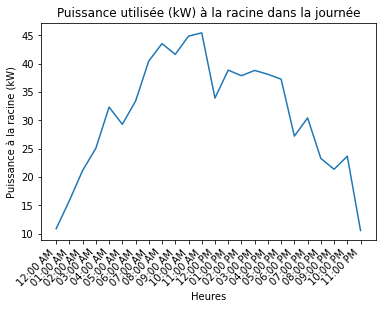

In [17]:
# Générer un premier dictionnaire de matrice et déterminer la somme de chaque
y = list(sum_by_hour)
x = [datetime.time(i).strftime("%I:00 %p") for i in range(0, 24)]

create_fig(x, y)  

In [18]:
print(best_evaluation)

45.45000000000002


### Fonction principale PASA

In [19]:
# utiliser PASA
# Afficher le premier et le dernier graphique ?